In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from collections import Counter
import random
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

In [7]:
# Dataset paths - Update these paths according to your dataset location
DATASET_PATH = "../../Data/images/"  # Change this to your dataset path
TRAIN_PATH = os.path.join(DATASET_PATH, "train")
VAL_PATH = os.path.join(DATASET_PATH, "validation")

# Emotion labels (common FER2013 emotions)
EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Check if paths exist
print(f"Dataset path exists: {os.path.exists(DATASET_PATH)}")
print(f"Train path exists: {os.path.exists(TRAIN_PATH)}")
print(f"Validation path exists: {os.path.exists(VAL_PATH)}")

if os.path.exists(TRAIN_PATH):
    print(f"\nTrain folders: {os.listdir(TRAIN_PATH)}")
if os.path.exists(VAL_PATH):
    print(f"Validation folders: {os.listdir(VAL_PATH)}")

Dataset path exists: True
Train path exists: True
Validation path exists: True

Train folders: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Validation folders: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [8]:
def analyze_dataset_structure(base_path, split_name):
    """Analyze the structure and count images in each emotion folder"""
    structure = {}
    total_images = 0
    
    print(f"\n{split_name.upper()} SET ANALYSIS")
    print("=" * 50)
    
    for emotion in EMOTIONS:
        emotion_path = os.path.join(base_path, emotion)
        if os.path.exists(emotion_path):
            # Count images in emotion folder
            image_files = [f for f in os.listdir(emotion_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            count = len(image_files)
            structure[emotion] = count
            total_images += count
            print(f"{emotion.capitalize()}: {count} images")
        else:
            structure[emotion] = 0
            print(f"{emotion.capitalize()}: Folder not found")
    
    print(f"\nTotal {split_name} images: {total_images}")
    return structure, total_images

# Analyze train and validation sets
train_structure, train_total = analyze_dataset_structure(TRAIN_PATH, "train")
val_structure, val_total = analyze_dataset_structure(VAL_PATH, "validation")

print(f"\nDATASET SUMMARY")
print("=" * 50)
print(f"Total training images: {train_total}")
print(f"Total validation images: {val_total}")
print(f"Total dataset images: {train_total + val_total}")


TRAIN SET ANALYSIS
Angry: 3993 images
Disgust: 436 images
Fear: 4103 images
Happy: 7164 images
Neutral: 4982 images
Sad: 4938 images
Surprise: 3205 images

Total train images: 28821

VALIDATION SET ANALYSIS
Angry: 960 images
Disgust: 111 images
Fear: 1018 images
Happy: 1825 images
Neutral: 1216 images
Sad: 1139 images
Surprise: 797 images

Total validation images: 7066

DATASET SUMMARY
Total training images: 28821
Total validation images: 7066
Total dataset images: 35887


In [9]:
# Create dataframes for analysis
train_df = pd.DataFrame(list(train_structure.items()), columns=['Emotion', 'Count'])
val_df = pd.DataFrame(list(val_structure.items()), columns=['Emotion', 'Count'])

# Add percentage columns
train_df['Percentage'] = (train_df['Count'] / train_total * 100).round(2)
val_df['Percentage'] = (val_df['Count'] / val_total * 100).round(2)

# Display distribution tables
print("TRAINING SET DISTRIBUTION")
print(train_df.to_string(index=False))

print("\nVALIDATION SET DISTRIBUTION")
print(val_df.to_string(index=False))

TRAINING SET DISTRIBUTION
 Emotion  Count  Percentage
   angry   3993       13.85
 disgust    436        1.51
    fear   4103       14.24
   happy   7164       24.86
 neutral   4982       17.29
     sad   4938       17.13
surprise   3205       11.12

VALIDATION SET DISTRIBUTION
 Emotion  Count  Percentage
   angry    960       13.59
 disgust    111        1.57
    fear   1018       14.41
   happy   1825       25.83
 neutral   1216       17.21
     sad   1139       16.12
surprise    797       11.28


In [10]:
# Calculate class imbalance metrics
def calculate_imbalance_metrics(df, set_name):
    """Calculate class imbalance metrics"""
    counts = df['Count'].values
    max_count = counts.max()
    min_count = counts.min()
    mean_count = counts.mean()
    std_count = counts.std()
    
    # Imbalance ratio
    imbalance_ratio = max_count / min_count
    
    # Coefficient of variation
    cv = std_count / mean_count
    
    print(f"\n{set_name.upper()} SET IMBALANCE ANALYSIS")
    print("=" * 40)
    print(f"Maximum class size: {max_count}")
    print(f"Minimum class size: {min_count}")
    print(f"Mean class size: {mean_count:.2f}")
    print(f"Standard deviation: {std_count:.2f}")
    print(f"Imbalance ratio (max/min): {imbalance_ratio:.2f}")
    print(f"Coefficient of variation: {cv:.3f}")
    
    # Interpretation
    if imbalance_ratio > 10:
        balance_status = "Severely imbalanced"
    elif imbalance_ratio > 5:
        balance_status = "Moderately imbalanced"
    elif imbalance_ratio > 2:
        balance_status = "Slightly imbalanced"
    else:
        balance_status = "Well balanced"
    
    print(f"Balance status: {balance_status}")
    return imbalance_ratio, cv

train_imbalance, train_cv = calculate_imbalance_metrics(train_df, "train")
val_imbalance, val_cv = calculate_imbalance_metrics(val_df, "validation")


TRAIN SET IMBALANCE ANALYSIS
Maximum class size: 7164
Minimum class size: 436
Mean class size: 4117.29
Standard deviation: 1893.73
Imbalance ratio (max/min): 16.43
Coefficient of variation: 0.460
Balance status: Severely imbalanced

VALIDATION SET IMBALANCE ANALYSIS
Maximum class size: 1825
Minimum class size: 111
Mean class size: 1009.43
Standard deviation: 475.01
Imbalance ratio (max/min): 16.44
Coefficient of variation: 0.471
Balance status: Severely imbalanced


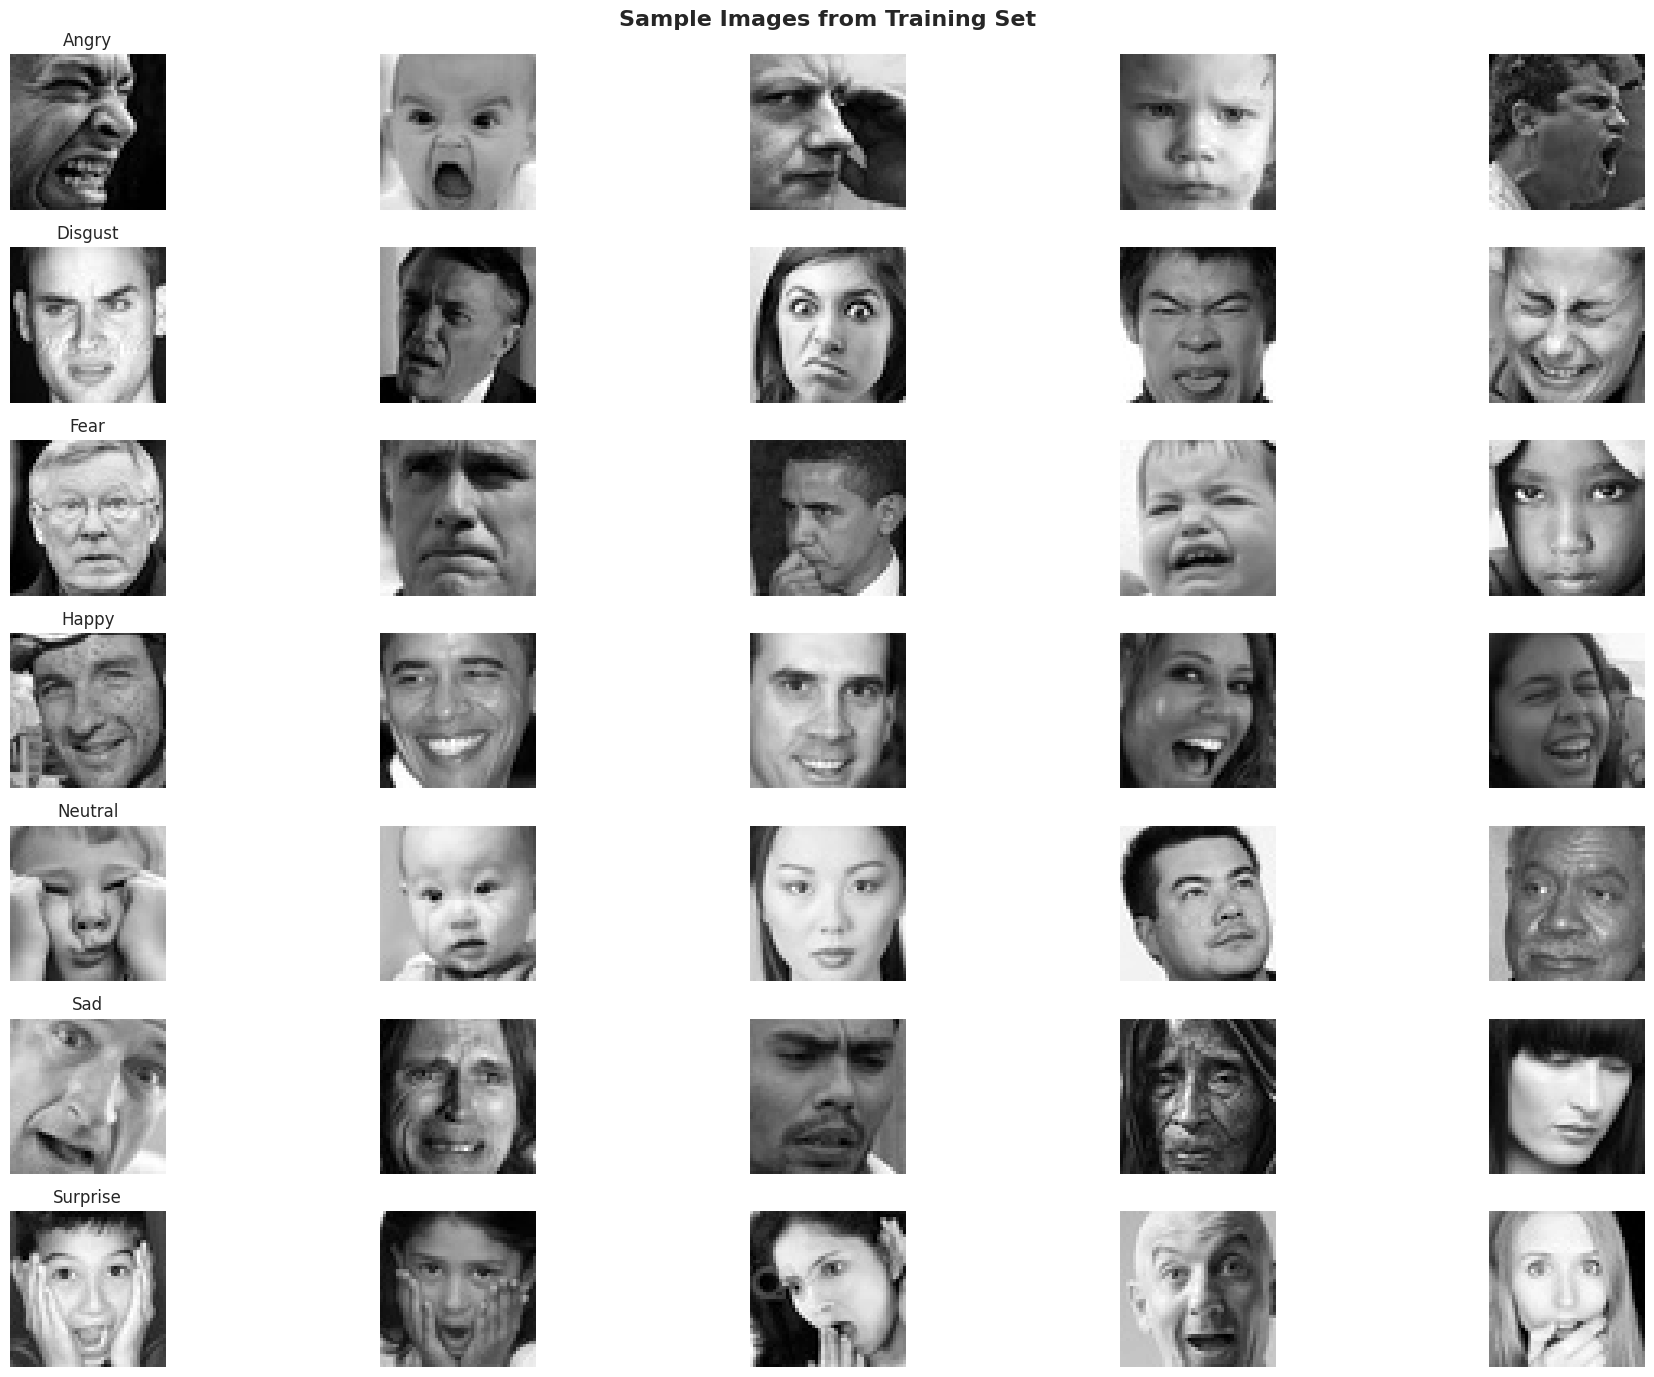

In [11]:
def load_sample_images(base_path, emotion, num_samples=5):
    """Load sample images from an emotion folder"""
    emotion_path = os.path.join(base_path, emotion)
    if not os.path.exists(emotion_path):
        return []
    
    image_files = [f for f in os.listdir(emotion_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if len(image_files) == 0:
        return []
    
    # Randomly sample images
    sample_files = random.sample(image_files, min(num_samples, len(image_files)))
    
    images = []
    for file in sample_files:
        img_path = os.path.join(emotion_path, file)
        try:
            img = Image.open(img_path)
            images.append(np.array(img))
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
    
    return images

# Display sample images for each emotion
def display_emotion_samples(base_path, set_name, num_samples=5):
    """Display sample images for each emotion"""
    fig, axes = plt.subplots(len(EMOTIONS), num_samples, figsize=(20, 14))
    fig.suptitle(f'Sample Images from {set_name.capitalize()} Set', fontsize=16, fontweight='bold')
    
    for i, emotion in enumerate(EMOTIONS):
        images = load_sample_images(base_path, emotion, num_samples)
        
        for j in range(num_samples):
            ax = axes[i, j] if len(EMOTIONS) > 1 else axes[j]
            
            if j < len(images):
                ax.imshow(images[j], cmap='gray' if len(images[j].shape) == 2 else None)
                ax.set_title(f'{emotion.capitalize()}' if j == 0 else '')
            else:
                ax.text(0.5, 0.5, 'No Image', ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'{emotion.capitalize()}' if j == 0 else '')
            
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Display samples from training set
display_emotion_samples(TRAIN_PATH, "training", 5)

In [12]:
def analyze_image_properties(base_path, emotion, max_samples=100):
    """Analyze image properties like dimensions, channels, etc."""
    emotion_path = os.path.join(base_path, emotion)
    if not os.path.exists(emotion_path):
        return {}
    
    image_files = [f for f in os.listdir(emotion_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if len(image_files) == 0:
        return {}
    
    # Sample images for analysis
    sample_files = random.sample(image_files, min(max_samples, len(image_files)))
    
    properties = {
        'widths': [],
        'heights': [],
        'channels': [],
        'file_sizes': [],
        'modes': []
    }
    
    for file in sample_files:
        img_path = os.path.join(emotion_path, file)
        try:
            # Get file size
            file_size = os.path.getsize(img_path)
            properties['file_sizes'].append(file_size)
            
            # Open image and get properties
            with Image.open(img_path) as img:
                width, height = img.size
                properties['widths'].append(width)
                properties['heights'].append(height)
                properties['modes'].append(img.mode)
                
                # Convert to numpy array to check channels
                img_array = np.array(img)
                if len(img_array.shape) == 2:
                    properties['channels'].append(1)  # Grayscale
                else:
                    properties['channels'].append(img_array.shape[2])  # Color channels
                    
        except Exception as e:
            print(f"Error analyzing image {img_path}: {e}")
            continue
    
    return properties

# Analyze properties for all emotions
print("ANALYZING IMAGE PROPERTIES...")
all_properties = {'widths': [], 'heights': [], 'channels': [], 'file_sizes': [], 'modes': []}

for emotion in EMOTIONS:
    props = analyze_image_properties(TRAIN_PATH, emotion, max_samples=50)
    for key in all_properties.keys():
        all_properties[key].extend(props.get(key, []))

# Calculate statistics
if all_properties['widths']:
    print("\nIMAGE PROPERTIES ANALYSIS")
    print("=" * 40)
    print(f"Width - Min: {min(all_properties['widths'])}, Max: {max(all_properties['widths'])}, Mean: {np.mean(all_properties['widths']):.1f}")
    print(f"Height - Min: {min(all_properties['heights'])}, Max: {max(all_properties['heights'])}, Mean: {np.mean(all_properties['heights']):.1f}")
    print(f"File Size - Min: {min(all_properties['file_sizes'])/1024:.1f}KB, Max: {max(all_properties['file_sizes'])/1024:.1f}KB, Mean: {np.mean(all_properties['file_sizes'])/1024:.1f}KB")
    print(f"Image Modes: {Counter(all_properties['modes'])}")
    print(f"Channels: {Counter(all_properties['channels'])}")
else:
    print("No images found for analysis")

ANALYZING IMAGE PROPERTIES...

IMAGE PROPERTIES ANALYSIS
Width - Min: 48, Max: 48, Mean: 48.0
Height - Min: 48, Max: 48, Mean: 48.0
File Size - Min: 0.9KB, Max: 2.1KB, Mean: 1.5KB
Image Modes: Counter({'L': 350})
Channels: Counter({1: 350})


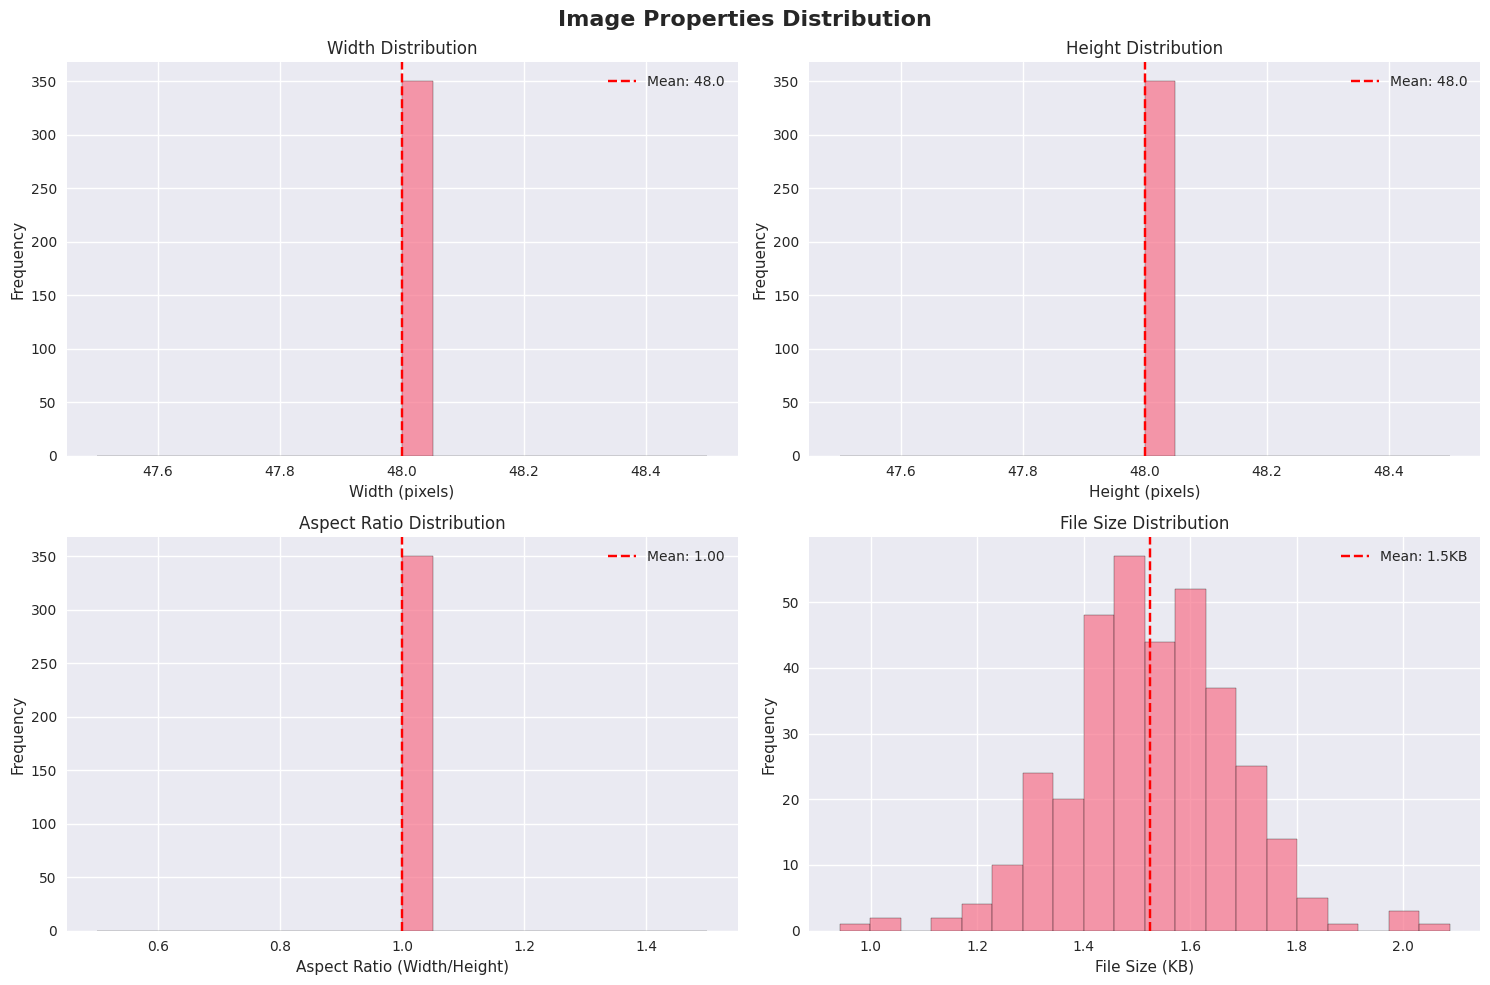

In [13]:
if all_properties['widths']:
    # Create visualization of image dimensions
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Image Properties Distribution', fontsize=16, fontweight='bold')
    
    # Width distribution
    axes[0,0].hist(all_properties['widths'], bins=20, alpha=0.7, edgecolor='black')
    axes[0,0].set_title('Width Distribution')
    axes[0,0].set_xlabel('Width (pixels)')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].axvline(np.mean(all_properties['widths']), color='red', linestyle='--', label=f'Mean: {np.mean(all_properties["widths"]):.1f}')
    axes[0,0].legend()
    
    # Height distribution
    axes[0,1].hist(all_properties['heights'], bins=20, alpha=0.7, edgecolor='black')
    axes[0,1].set_title('Height Distribution')
    axes[0,1].set_xlabel('Height (pixels)')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].axvline(np.mean(all_properties['heights']), color='red', linestyle='--', label=f'Mean: {np.mean(all_properties["heights"]):.1f}')
    axes[0,1].legend()
    
    # Aspect ratio
    aspect_ratios = [w/h for w, h in zip(all_properties['widths'], all_properties['heights'])]
    axes[1,0].hist(aspect_ratios, bins=20, alpha=0.7, edgecolor='black')
    axes[1,0].set_title('Aspect Ratio Distribution')
    axes[1,0].set_xlabel('Aspect Ratio (Width/Height)')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].axvline(np.mean(aspect_ratios), color='red', linestyle='--', label=f'Mean: {np.mean(aspect_ratios):.2f}')
    axes[1,0].legend()
    
    # File size distribution
    file_sizes_kb = [size/1024 for size in all_properties['file_sizes']]
    axes[1,1].hist(file_sizes_kb, bins=20, alpha=0.7, edgecolor='black')
    axes[1,1].set_title('File Size Distribution')
    axes[1,1].set_xlabel('File Size (KB)')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].axvline(np.mean(file_sizes_kb), color='red', linestyle='--', label=f'Mean: {np.mean(file_sizes_kb):.1f}KB')
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()
else:
    print("No image properties to visualize")

In [14]:
def analyze_pixel_intensities(base_path, emotion, max_samples=50):
    """Analyze pixel intensity statistics for an emotion"""
    emotion_path = os.path.join(base_path, emotion)
    if not os.path.exists(emotion_path):
        return None
    
    image_files = [f for f in os.listdir(emotion_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if len(image_files) == 0:
        return None
    
    sample_files = random.sample(image_files, min(max_samples, len(image_files)))
    
    intensities = []
    
    for file in sample_files:
        img_path = os.path.join(emotion_path, file)
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                intensities.extend(img.flatten())
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue
    
    if intensities:
        return {
            'mean': np.mean(intensities),
            'std': np.std(intensities),
            'min': np.min(intensities),
            'max': np.max(intensities),
            'intensities': intensities
        }
    return None

# Analyze pixel intensities for each emotion
print("ANALYZING PIXEL INTENSITIES...")
intensity_stats = {}

for emotion in EMOTIONS:
    stats = analyze_pixel_intensities(TRAIN_PATH, emotion, max_samples=30)
    if stats:
        intensity_stats[emotion] = stats

# Display intensity statistics
if intensity_stats:
    print("\nPIXEL INTENSITY STATISTICS")
    print("=" * 50)
    
    intensity_df = pd.DataFrame({
        emotion: [stats['mean'], stats['std'], stats['min'], stats['max']] 
        for emotion, stats in intensity_stats.items()
    }, index=['Mean', 'Std Dev', 'Min', 'Max'])
    
    print(intensity_df.round(2))
else:
    print("No intensity statistics available")

ANALYZING PIXEL INTENSITIES...

PIXEL INTENSITY STATISTICS
          angry  disgust    fear   happy  neutral     sad  surprise
Mean     132.84   136.87  130.17  132.72   133.70  109.45    145.52
Std Dev   61.73    61.94   64.10   67.96    68.04   63.22     64.21
Min        0.00     0.00    0.00    0.00     0.00    0.00      0.00
Max      255.00   255.00  255.00  255.00   255.00  255.00    255.00


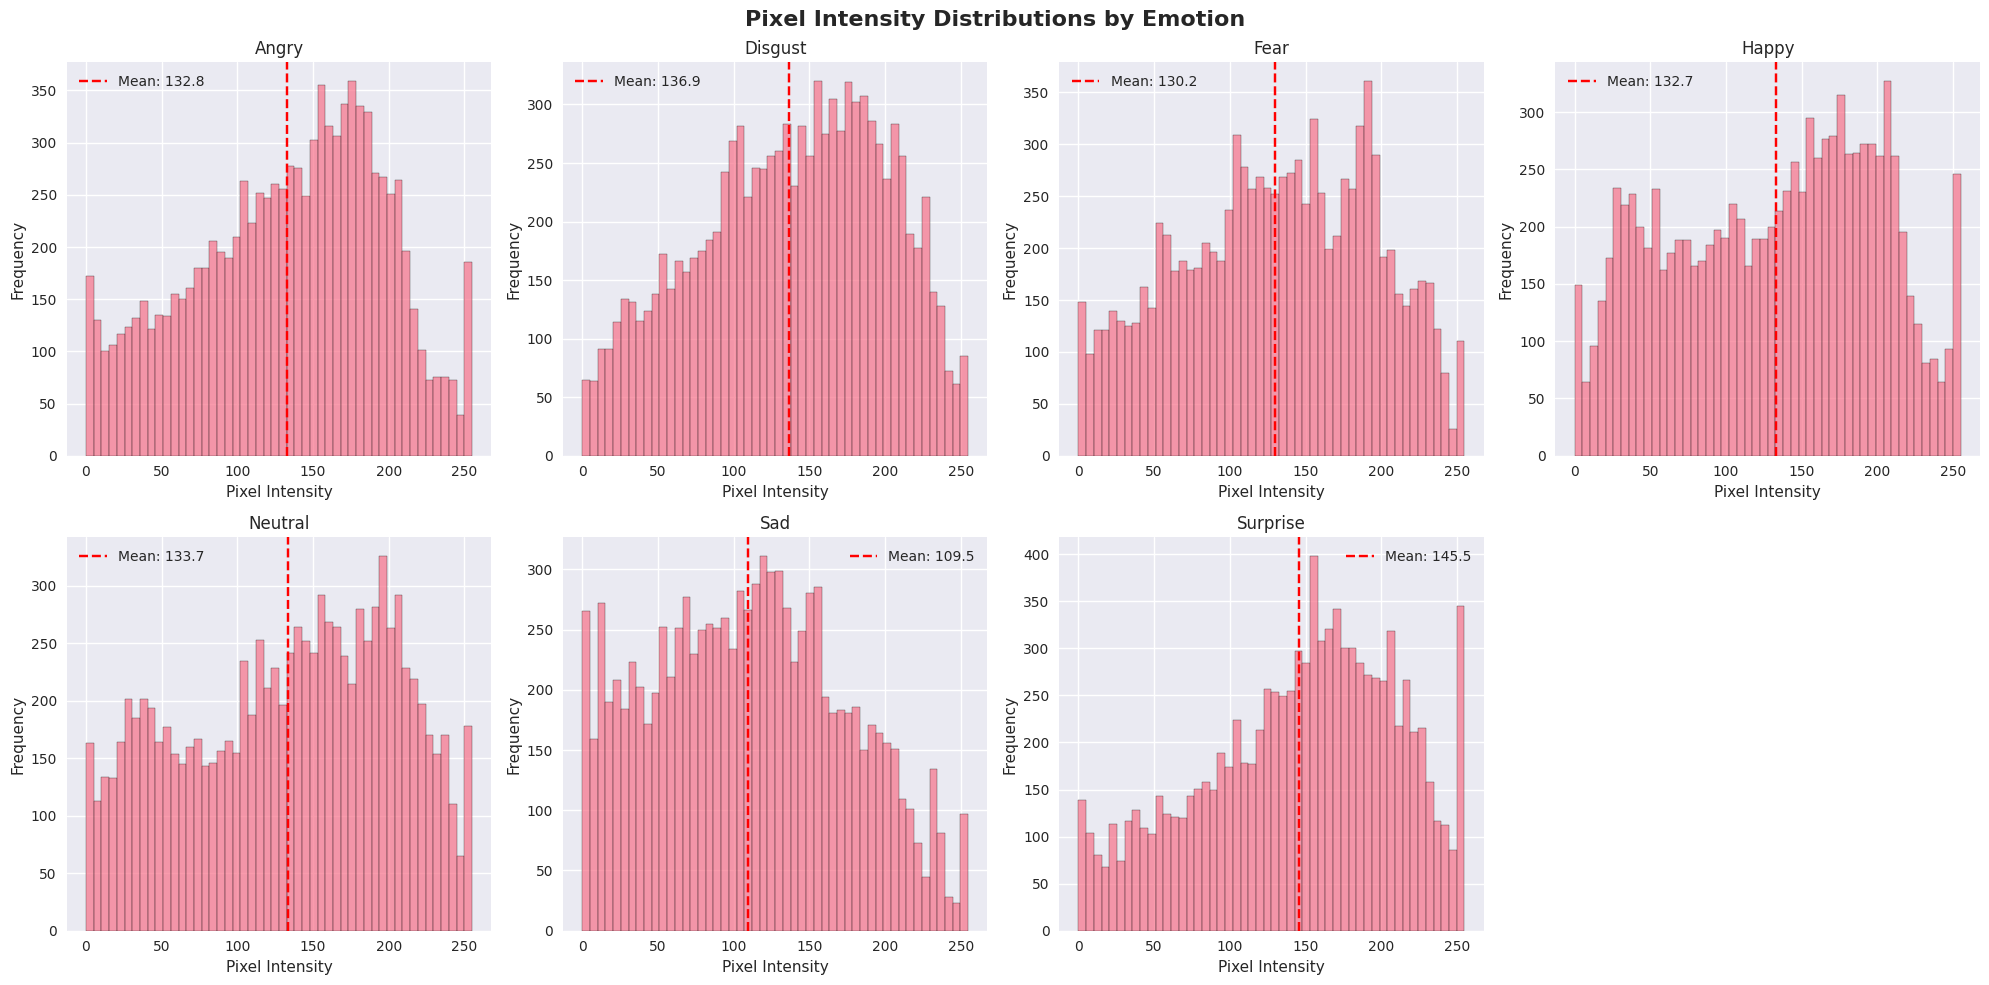

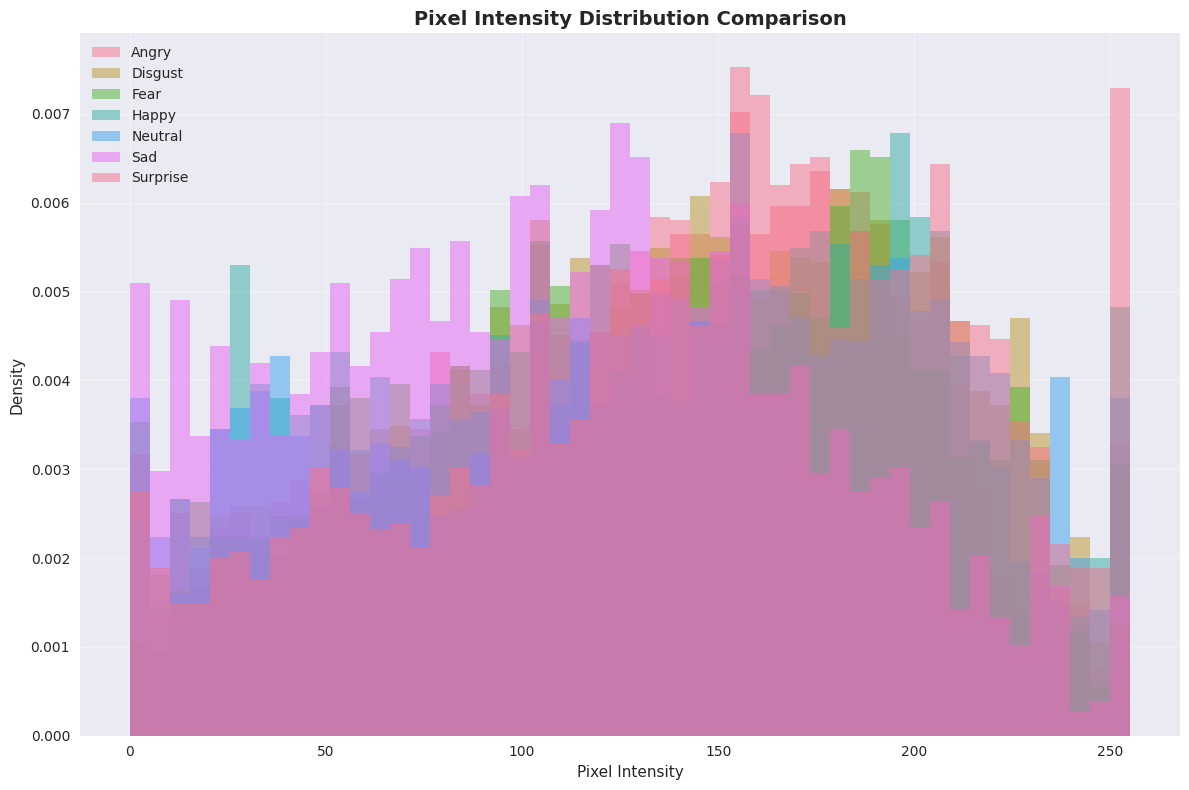

In [15]:
if intensity_stats:
    # Create pixel intensity distribution plots
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle('Pixel Intensity Distributions by Emotion', fontsize=16, fontweight='bold')
    
    for i, (emotion, stats) in enumerate(intensity_stats.items()):
        row = i // 4
        col = i % 4
        
        if row < 2 and col < 4:
            # Sample intensities for plotting (to avoid memory issues)
            sample_intensities = random.sample(stats['intensities'], min(10000, len(stats['intensities'])))
            
            axes[row, col].hist(sample_intensities, bins=50, alpha=0.7, edgecolor='black')
            axes[row, col].set_title(f'{emotion.capitalize()}')
            axes[row, col].set_xlabel('Pixel Intensity')
            axes[row, col].set_ylabel('Frequency')
            axes[row, col].axvline(stats['mean'], color='red', linestyle='--', label=f'Mean: {stats["mean"]:.1f}')
            axes[row, col].legend()
    
    # Hide empty subplots if there are fewer than 8 emotions
    for i in range(len(intensity_stats), 8):
        row = i // 4
        col = i % 4
        if row < 2 and col < 4:
            axes[row, col].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Create comparison plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    for emotion, stats in intensity_stats.items():
        sample_intensities = random.sample(stats['intensities'], min(5000, len(stats['intensities'])))
        ax.hist(sample_intensities, bins=50, alpha=0.5, label=emotion.capitalize(), density=True)
    
    ax.set_title('Pixel Intensity Distribution Comparison', fontsize=14, fontweight='bold')
    ax.set_xlabel('Pixel Intensity')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No intensity data available for visualization")

In [16]:
def assess_data_quality(base_path, split_name):
    """Assess data quality by checking for corrupted/invalid images"""
    print(f"\nDATA QUALITY ASSESSMENT - {split_name.upper()}")
    print("=" * 50)
    
    total_files = 0
    valid_files = 0
    corrupted_files = []
    
    for emotion in EMOTIONS:
        emotion_path = os.path.join(base_path, emotion)
        if not os.path.exists(emotion_path):
            continue
            
        image_files = [f for f in os.listdir(emotion_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        emotion_total = len(image_files)
        emotion_valid = 0
        
        for file in image_files:
            img_path = os.path.join(emotion_path, file)
            try:
                # Try to open and verify the image
                with Image.open(img_path) as img:
                    img.verify()  # Verify it's a valid image
                    emotion_valid += 1
                    valid_files += 1
            except Exception as e:
                corrupted_files.append(f"{emotion}/{file}: {str(e)}")
            
            total_files += 1
        
        if emotion_total > 0:
            quality_rate = (emotion_valid / emotion_total) * 100
            print(f"{emotion.capitalize()}: {emotion_valid}/{emotion_total} valid ({quality_rate:.1f}%)")
    
    overall_quality = (valid_files / total_files) * 100 if total_files > 0 else 0
    print(f"\nOverall Quality: {valid_files}/{total_files} valid ({overall_quality:.1f}%)")
    
    if corrupted_files:
        print(f"\nCorrupted Files Found: {len(corrupted_files)}")
        for file in corrupted_files[:10]:  # Show first 10
            print(f"  - {file}")
        if len(corrupted_files) > 10:
            print(f"  ... and {len(corrupted_files) - 10} more")
    else:
        print("\nNo corrupted files found!")
    
    return valid_files, total_files, corrupted_files

# Assess data quality for both sets
train_valid, train_total_files, train_corrupted = assess_data_quality(TRAIN_PATH, "train")
val_valid, val_total_files, val_corrupted = assess_data_quality(VAL_PATH, "validation")


DATA QUALITY ASSESSMENT - TRAIN
Angry: 3993/3993 valid (100.0%)
Disgust: 436/436 valid (100.0%)
Fear: 4103/4103 valid (100.0%)
Happy: 7164/7164 valid (100.0%)
Neutral: 4982/4982 valid (100.0%)
Sad: 4938/4938 valid (100.0%)
Surprise: 3205/3205 valid (100.0%)

Overall Quality: 28821/28821 valid (100.0%)

No corrupted files found!

DATA QUALITY ASSESSMENT - VALIDATION
Angry: 960/960 valid (100.0%)
Disgust: 111/111 valid (100.0%)
Fear: 1018/1018 valid (100.0%)
Happy: 1825/1825 valid (100.0%)
Neutral: 1216/1216 valid (100.0%)
Sad: 1139/1139 valid (100.0%)
Surprise: 797/797 valid (100.0%)

Overall Quality: 7066/7066 valid (100.0%)

No corrupted files found!


In [19]:
# Create comprehensive summary report
print("\n" + "="*70)
print("                    FER2013 DATASET SUMMARY REPORT")
print("="*70)

print(f"\n📊 DATASET OVERVIEW:")
print(f"   • Total Training Images: {train_total:,}")
print(f"   • Total Validation Images: {val_total:,}")
print(f"   • Total Dataset Images: {train_total + val_total:,}")
print(f"   • Number of Emotion Classes: {len(EMOTIONS)}")
print(f"   • Emotions: {', '.join([e.capitalize() for e in EMOTIONS])}")

print(f"\n⚖️ CLASS DISTRIBUTION:")
print(f"   • Training Set Imbalance Ratio: {train_imbalance:.2f}")
print(f"   • Validation Set Imbalance Ratio: {val_imbalance:.2f}")
print(f"   • Most Common Class (Train): {train_df.loc[train_df['Count'].idxmax(), 'Emotion'].capitalize()} ({train_df['Count'].max():,} images)")
print(f"   • Least Common Class (Train): {train_df.loc[train_df['Count'].idxmin(), 'Emotion'].capitalize()} ({train_df['Count'].min():,} images)")

print(f"\n🔍 DATA QUALITY:")
print(f"   • Training Set Quality: {train_quality:.1f}% ({train_valid}/{train_total_files} valid)")
print(f"   • Validation Set Quality: {val_quality:.1f}% ({val_valid}/{val_total_files} valid)")
print(f"   • Corrupted Files Found: {len(train_corrupted) + len(val_corrupted)}")

if all_properties['widths']:
    print(f"\n📐 IMAGE PROPERTIES:")
    print(f"   • Average Width: {np.mean(all_properties['widths']):.0f} pixels")
    print(f"   • Average Height: {np.mean(all_properties['heights']):.0f} pixels")
    print(f"   • Average File Size: {np.mean(all_properties['file_sizes'])/1024:.1f} KB")
    print(f"   • Color Modes: {dict(Counter(all_properties['modes']))}")




                    FER2013 DATASET SUMMARY REPORT

📊 DATASET OVERVIEW:
   • Total Training Images: 28,821
   • Total Validation Images: 7,066
   • Total Dataset Images: 35,887
   • Number of Emotion Classes: 7
   • Emotions: Angry, Disgust, Fear, Happy, Neutral, Sad, Surprise

⚖️ CLASS DISTRIBUTION:
   • Training Set Imbalance Ratio: 16.43
   • Validation Set Imbalance Ratio: 16.44
   • Most Common Class (Train): Happy (7,164 images)
   • Least Common Class (Train): Disgust (436 images)

🔍 DATA QUALITY:
   • Training Set Quality: 100.0% (28821/28821 valid)
   • Validation Set Quality: 100.0% (7066/7066 valid)
   • Corrupted Files Found: 0

📐 IMAGE PROPERTIES:
   • Average Width: 48 pixels
   • Average Height: 48 pixels
   • Average File Size: 1.5 KB
   • Color Modes: {'L': 350}
